Данный файл служит для препроцессинга всех выбранных датасетов автомобилей. Примерная схема для итоговый директорий с автомобилями будет выглядеть так:

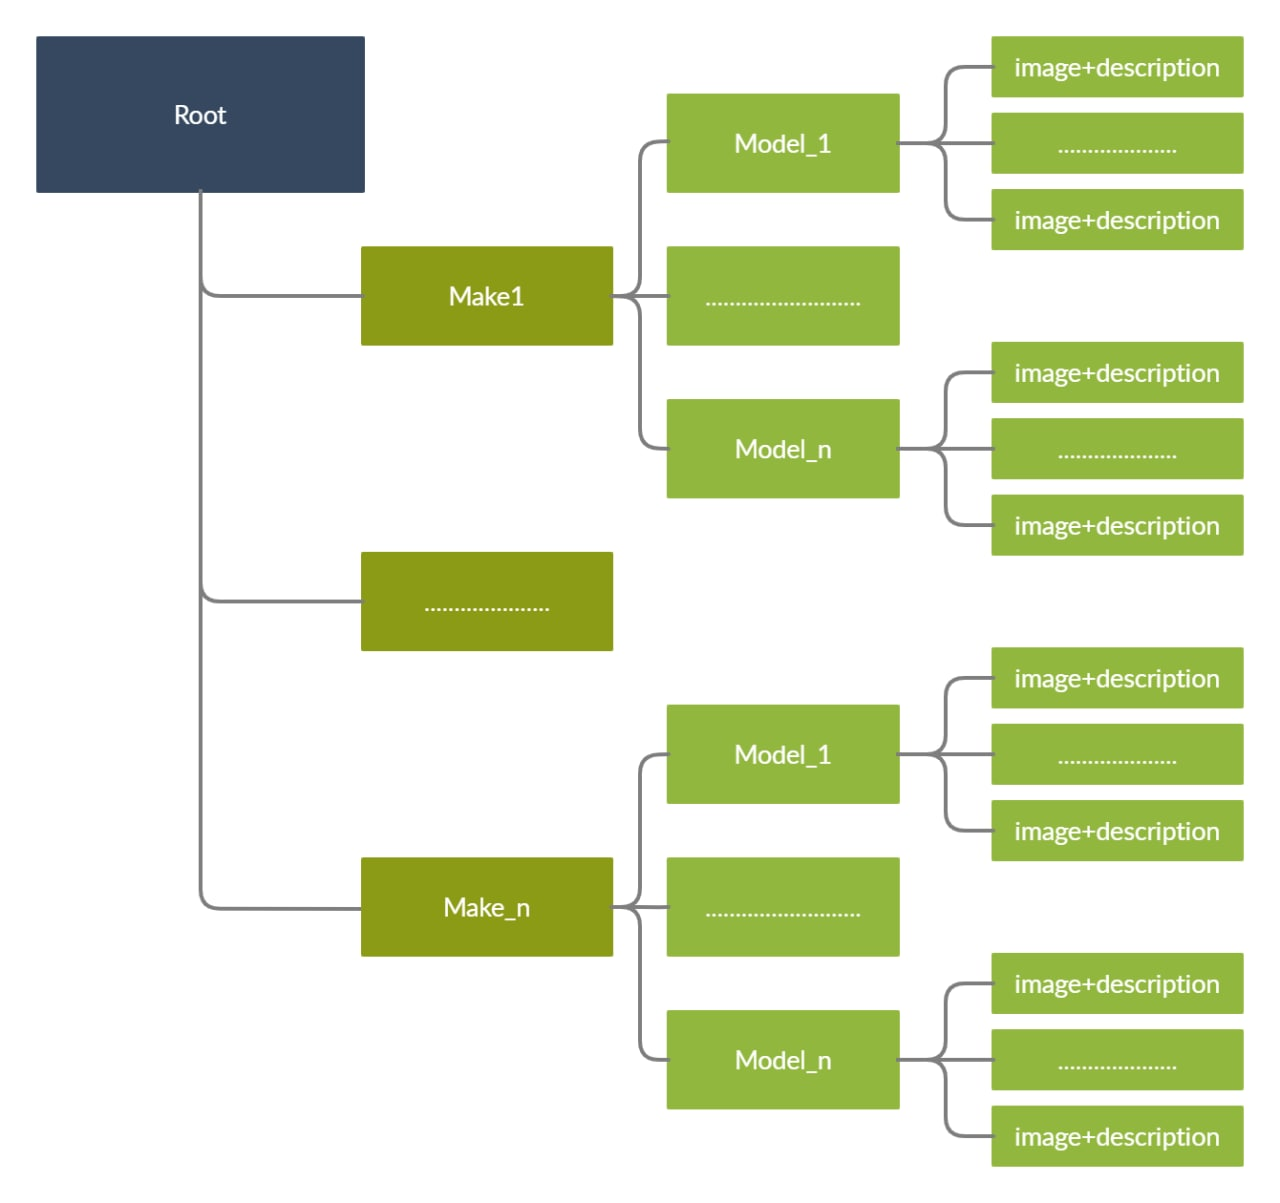

In [24]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

# Stanford Cars dataset reading

In [2]:
devkit_path = Path('StanfordCarsDataset/devkit')
train_path = Path('StanfordCarsDataset/cars_train')
test_path = Path('StanfordCarsDataset/cars_test')

## DevKit

In [3]:
os.listdir(devkit_path)

['cars_meta.mat',
 'cars_test_annos.mat',
 'cars_train_annos.mat',
 'eval_train.m',
 'README.txt',
 'train_perfect_preds.txt']

In [4]:
with open(devkit_path/'README.txt') as f:
    for line in f:
        print(line)

This file gives documentation for the cars 196 dataset.

(http://ai.stanford.edu/~jkrause/cars/car_dataset.html)



----------------------------------------

Metadata/Annotations

----------------------------------------

Descriptions of the files are as follows:



-cars_meta.mat:

  Contains a cell array of class names, one for each class.



-cars_train_annos.mat:

  Contains the variable 'annotations', which is a struct array of length

  num_images and where each element has the fields:

    bbox_x1: Min x-value of the bounding box, in pixels

    bbox_x2: Max x-value of the bounding box, in pixels

    bbox_y1: Min y-value of the bounding box, in pixels

    bbox_y2: Max y-value of the bounding box, in pixels

    class: Integral id of the class the image belongs to.

    fname: Filename of the image within the folder of images.



-cars_test_annos.mat:

  Same format as 'cars_train_annos.mat', except the class is not provided.



----------------------------------------

Submiss

In [5]:
cars_meta = loadmat(devkit_path/'cars_meta.mat')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path/'cars_test_annos.mat')

# Loading labels

Нам нужно разбить лейблы на бренд, модель и год. Главной проблемой стоит тот факт, что автомобильный бренд не всегда состоит из одного слова. Поэтому в любом случае придётся прибегнуть к доделыванию данных за алгоритмом.

Решением выбрано создание отдельного файла с брендами, где указаны альтернативные названия каждого бренда. В таком случае, если мы встретим, например, Land Rover, то мы найдём бренд Land и сможем дополнить его до Land Rover.

In [47]:
# !TODO поменять список на файл (возможно даже на файл со всеми брендами)
multi_word_brands = ['AM General', 'Alfa Romeo', 'Aston Martin', 'Land Rover']
multi_word_brands_correction = {brand.split()[0]:brand for brand in multi_word_brands}
multi_word_brands_correction

{'AM': 'AM General',
 'Alfa': 'Alfa Romeo',
 'Aston': 'Aston Martin',
 'Land': 'Land Rover'}

In [48]:
labels = {'brand':[], 'model':[], 'year':[]}
for class_name in cars_meta['class_names'][0]:
    class_name_list = class_name[0].split()
    brand = class_name_list[0]
    if brand in multi_word_brands_correction:
        brand = multi_word_brands_correction[brand]
        model = ' '.join(class_name_list[2:-1])
    else:
        model = ' '.join(class_name_list[1:-1])
    year = class_name_list[-1]
    
    labels['brand'].append(brand)
    labels['model'].append(model)
    labels['year'].append(year)
labels = pd.DataFrame(labels)
labels

,brand,model,year
0,AM General,Hummer SUV,2000
1,Acura,RL Sedan,2012
2,Acura,TL Sedan,2012
3,Acura,TL Type-S,2008
4,Acura,TSX Sedan,2012
...,...,...,...
191,Volkswagen,Beetle Hatchback,2012
192,Volvo,C30 Hatchback,2012
193,Volvo,240 Sedan,1993
194,Volvo,XC90 SUV,2007


# Loading cars train

In [49]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
frame[0][4] = int(frame[0][4]) # change dtype of class to prevent numeric overflow 
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path/f for f in df_train['fname']] #  Appending Path
print(df_train.dtypes)
df_train.head()

bbox_x1     int16
bbox_y1     int16
bbox_x2     int16
bbox_y2     int16
class       int64
fname      object
dtype: object


,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,StanfordCarsDataset\cars_train\00001.jpg
1,36,116,868,587,2,StanfordCarsDataset\cars_train\00002.jpg
2,85,109,601,381,90,StanfordCarsDataset\cars_train\00003.jpg
3,621,393,1484,1096,133,StanfordCarsDataset\cars_train\00004.jpg
4,14,36,133,99,105,StanfordCarsDataset\cars_train\00005.jpg


# Merging labels

In [50]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,brand,model,year
0,39,116,569,375,13,StanfordCarsDataset\cars_train\00001.jpg,Audi,TTS Coupe,2012
1,36,116,868,587,2,StanfordCarsDataset\cars_train\00002.jpg,Acura,TL Sedan,2012
2,85,109,601,381,90,StanfordCarsDataset\cars_train\00003.jpg,Dodge,Dakota Club Cab,2007
3,621,393,1484,1096,133,StanfordCarsDataset\cars_train\00004.jpg,Hyundai,Sonata Hybrid Sedan,2012
4,14,36,133,99,105,StanfordCarsDataset\cars_train\00005.jpg,Ford,F-450 Super Duty Crew Cab,2012


# Loading cars test

In [120]:
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [test_path/f for f in df_test['fname']] #  Appending Path
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,StanfordCarsDataset\cars_test\00001.jpg
1,100,19,576,203,StanfordCarsDataset\cars_test\00002.jpg
2,51,105,968,659,StanfordCarsDataset\cars_test\00003.jpg
3,67,84,581,407,StanfordCarsDataset\cars_test\00004.jpg
4,140,151,593,339,StanfordCarsDataset\cars_test\00005.jpg


# Displaying image 

In [121]:
# Returns (Image, title, rectangle patch) for drawing
def get_assets(df, i):
    is_train = df is df_train
    folder = train_path if is_train else test_path
    image = Image.open(df['fname'][i])
    title = df['labels'][i] if is_train else 'Unclassified'

    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

In [122]:
def display_image(df, i):
    image, title, rect = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

Acura TL Sedan 2012


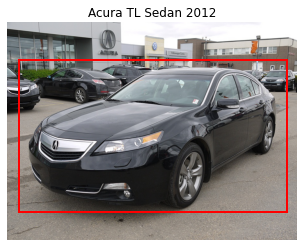

In [125]:
display_image(df_train, 1)

In [126]:
def display_range(end, start = 0):

    n = end - start
    fig, ax = plt.subplots(n, 2, figsize=(15, 5*end))

    for i in range(start, end):
        line = i - start
        
        im, title, rect = get_assets(df_train, i)
        sub = ax[line, 0]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
        im, title, rect = get_assets(df_test, i)
        sub = ax[line, 1]
        sub.imshow(im)
        sub.axis('off')
        sub.set_title(title)
        sub.add_patch(rect)
        
    plt.show()

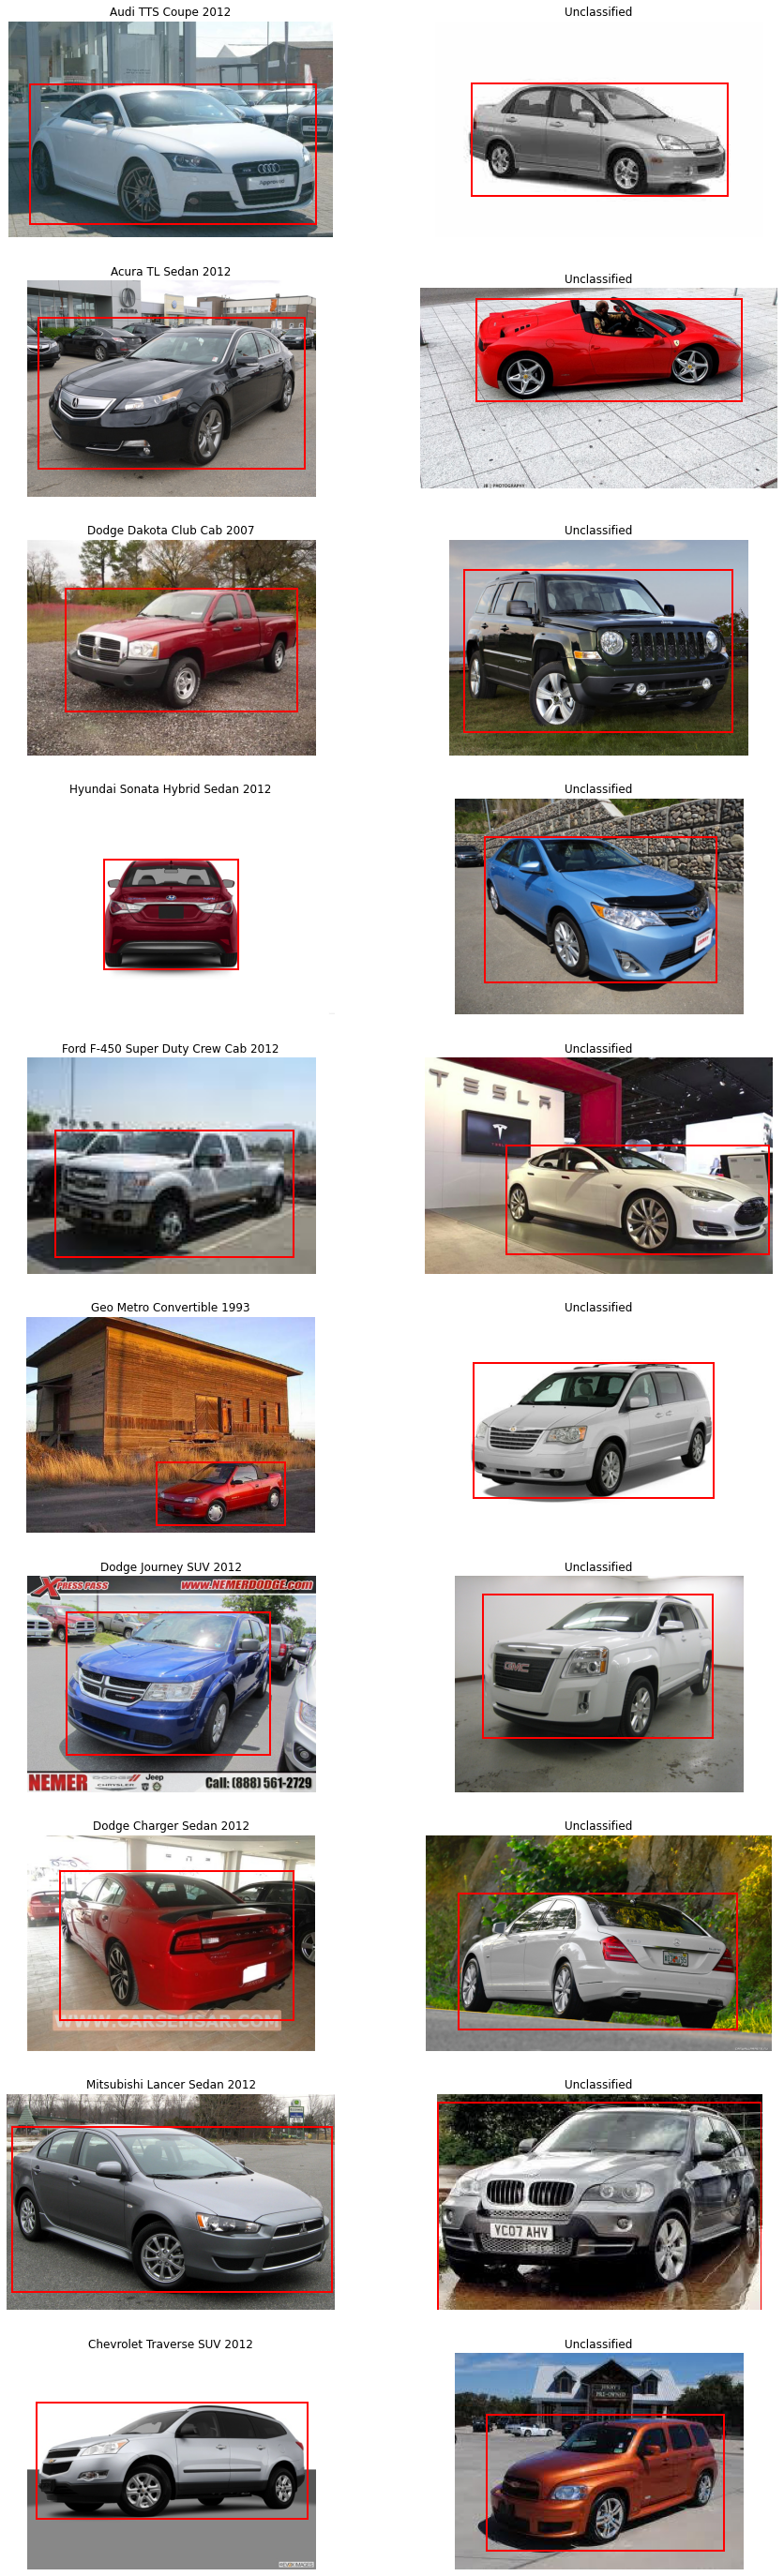

In [128]:
display_range(10)